Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

#Reading in the data 

In [1]:
import pandas as pd
#Reading in the data I split in a seperate notebook so I could read into Github
url1 = 'https://raw.githubusercontent.com/zacksnyder-lsds/Unit_1_build_week/master/kiva1%20(1).csv'
url2 = 'https://raw.githubusercontent.com/zacksnyder-lsds/Unit_1_build_week/master/kiva2.csv'
url3 = 'https://raw.githubusercontent.com/zacksnyder-lsds/Unit_1_build_week/master/kiva3.csv'
url4 = 'https://raw.githubusercontent.com/zacksnyder-lsds/Unit_1_build_week/master/kiva4.csv'
url5 = 'https://raw.githubusercontent.com/zacksnyder-lsds/Unit_1_build_week/master/kiva5.csv'
url6 = 'https://raw.githubusercontent.com/zacksnyder-lsds/Unit_1_build_week/master/kiva6.csv'
url7 = 'https://raw.githubusercontent.com/zacksnyder-lsds/Unit_1_build_week/master/kiva7.csv'
url8 = 'https://raw.githubusercontent.com/zacksnyder-lsds/Unit_1_build_week/master/kiva8.csv'
url9 = 'https://raw.githubusercontent.com/zacksnyder-lsds/Unit_1_build_week/master/kiva9.csv'
url10 = 'https://raw.githubusercontent.com/zacksnyder-lsds/Unit_1_build_week/master/kiva10.csv'

In [2]:
#converting the csv files back to dataframes for use 
kiva1 = pd.read_csv(url1)
kiva2 = pd.read_csv(url2)
kiva3 = pd.read_csv(url3)
kiva4 = pd.read_csv(url4)
kiva5 = pd.read_csv(url5)
kiva6 = pd.read_csv(url6)
kiva7 = pd.read_csv(url7)
kiva8 = pd.read_csv(url8)
kiva9 = pd.read_csv(url9)
kiva10 = pd.read_csv(url10)

In [3]:
#checking to make sure all the data read in smoothly 
[print(name.shape) for name in [kiva1,kiva2,kiva3,kiva4,kiva5,kiva6,kiva7,kiva8,kiva9,kiva10]]
kiva2.head()

(67120, 21)
(67120, 21)
(67120, 21)
(67120, 21)
(67120, 21)
(67120, 21)
(67120, 21)
(67120, 21)
(67120, 21)
(67125, 21)


,Unnamed: 0,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,67120,1081611,125.0,125.0,Clothing,Clothing,buy new clothes using ksh 5500 and second hand...,KE,Kenya,NaN,KES,NaN,2014-06-03 13:45:20+00:00,2014-06-19 05:35:49+00:00,2014-06-18 12:18:49+00:00,3.0,5,NaN,female,irregular,2014-06-03
1,67121,719419,425.0,425.0,Weaving,Arts,to purchase additional stock of bamboo to sell,PH,Philippines,"Brookes Point, Palawan",PHP,145.0,2014-06-03 06:28:43+00:00,2014-05-28 07:00:00+00:00,2014-06-09 00:31:06+00:00,8.0,17,NaN,female,irregular,2014-06-03
2,67122,719437,275.0,275.0,Fishing,Food,to buy an additional bundle of fishing nets,PH,Philippines,"Brookes Point, Palawan",PHP,145.0,2014-06-03 07:00:11+00:00,2014-05-28 07:00:00+00:00,2014-06-18 12:05:58+00:00,8.0,10,NaN,female,irregular,2014-06-03
3,67123,719717,450.0,450.0,Food Production/Sales,Food,to buy corn wholesale and lime.,SV,El Salvador,NaN,USD,81.0,2014-06-03 23:02:46+00:00,2014-05-28 07:00:00+00:00,2014-06-17 00:25:04+00:00,14.0,17,"volunteer_pick, volunteer_like",female,monthly,2014-06-03
4,67124,719548,475.0,475.0,Retail,Retail,To buy clothes and blankets to resell,JO,Jordan,Zarqa,JOD,185.0,2014-06-03 12:21:09+00:00,2014-05-27 07:00:00+00:00,2014-06-30 11:35:35+00:00,15.0,17,"#Single, #Woman Owned Biz",female,monthly,2014-06-03


In [4]:
#concatinating the dataframes back together to the original from Kaggle 
kiva = pd.concat([kiva1,kiva2,kiva3,kiva4,kiva5,kiva6,kiva7,kiva8,kiva9,kiva10])
kiva.reset_index()
print(kiva.shape)
kiva.sample(5)

(671205, 21)


,Unnamed: 0,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
12049,616129,1277964,2000.0,2000.0,Cosmetics Sales,Retail,helps an immigrant from Mexico expand her busi...,US,United States,NaN,USD,NaN,2017-04-11 00:00:00+00:00,2017-05-31 22:47:33+00:00,2017-05-26 16:37:26+00:00,18.0,30,"#Woman Owned Biz, user_favorite, user_favorite",female,monthly,2017-04-11
57661,191901,840024,725.0,725.0,Personal Housing Expenses,Housing,"to purchase sand, cement, brick and equipment ...",VN,Vietnam,Thanh Hoá,VND,121.0,2015-02-12 15:45:49+00:00,2015-02-09 08:00:00+00:00,2015-02-18 18:29:33+00:00,20.0,25,NaN,female,monthly,2015-02-12
20881,490721,1151224,1475.0,1475.0,Services,Services,to buy a laptop for her work.,PE,Peru,CUSCO,PEN,119.0,2016-09-15 16:17:59+00:00,2016-08-19 07:00:00+00:00,2016-09-21 21:20:41+00:00,6.0,42,"#Technology, user_favorite, user_favorite",female,irregular,2016-09-15
38463,441183,1101044,300.0,300.0,Fruits & Vegetables,Food,to purchase more fruit for her husband's fruit...,PK,Pakistan,Rawalpindi,PKR,247.0,2016-06-17 05:57:44+00:00,2016-06-08 07:00:00+00:00,2016-07-22 13:37:46+00:00,14.0,10,"#Parent, #Vegan",female,monthly,2016-06-17
28363,229723,877179,125.0,125.0,Fishing,Food,"to buy fishing net, gasoline for her boat and ...",PH,Philippines,"Roxas City, Capiz",PHP,145.0,2015-04-28 06:52:31+00:00,2015-04-08 07:00:00+00:00,2015-05-04 15:34:01+00:00,8.0,5,user_favorite,female,irregular,2015-04-28


In [5]:
#getting rid of the previous index column renamed unanamed 0 
kiva.drop('Unnamed: 0', axis=1, inplace=True)
kiva.sample(5)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
10852,1140211,3800.0,3800.0,Primary/secondary school costs,Education,to pay her children's school tuition fees,LB,Lebanon,Beirut,USD,77.0,2016-08-26 06:49:43+00:00,2016-08-08 07:00:00+00:00,2016-09-08 08:01:58+00:00,8.0,127,"#Schooling, #Repeat Borrower, #Parent, user_fa...","female, female, female, female, female",monthly,2016-08-26
483,653566,200.0,200.0,Home Appliances,Personal Use,To pay for appliances for the house.,PK,Pakistan,Rawalpindi,PKR,247.0,2014-01-03 07:53:25+00:00,2013-12-23 08:00:00+00:00,2014-01-04 04:27:19+00:00,12.0,5,NaN,female,irregular,2014-01-03
36813,819786,350.0,350.0,Services,Services,to add more business float,KE,Kenya,Eldoret,KES,133.0,2014-12-23 12:55:17+00:00,2014-12-09 08:00:00+00:00,2015-01-08 04:01:09+00:00,8.0,11,"#First Loan, #Technology",male,monthly,2014-12-23
66504,915089,525.0,525.0,Personal Housing Expenses,Housing,"to buy construction materials such as sand, ce...",MZ,Mozambique,"Boane, Maputo",MZN,23.0,2015-07-09 07:14:26+00:00,2015-06-30 07:00:00+00:00,2015-08-16 12:12:25+00:00,18.0,20,"#Single Parent, #Repeat Borrower, user_favorit...",female,monthly,2015-07-09
59469,711802,450.0,450.0,Food Production/Sales,Food,"to buy chicken, garlic, onion, soy sauce, cont...",WS,Samoa,Fasitoo Uta,WST,15.0,2014-05-19 07:22:00+00:00,2014-04-24 07:00:00+00:00,2014-05-21 13:47:34+00:00,14.0,14,NaN,female,irregular,2014-05-19


#Choosing My Target

In [6]:
list(kiva.columns)

['id',
 'funded_amount',
 'loan_amount',
 'activity',
 'sector',
 'use',
 'country_code',
 'country',
 'region',
 'currency',
 'partner_id',
 'posted_time',
 'disbursed_time',
 'funded_time',
 'term_in_months',
 'lender_count',
 'tags',
 'borrower_genders',
 'repayment_interval',
 'date']

The business problem I want to solve is given a varity of factors, what is the loan amount you should request on Kiva. Since the borrower decides how much money they need, and lenders determine if they'll accept the proposal, it could give borrowers an advantage to know approximatly how much to ask for to have the best chance of getting the funding 

###The best target column for this business problem will be funded_amount because it shows how much each request actually recieved 

###This will be a regression problem 

#Data Distribution 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


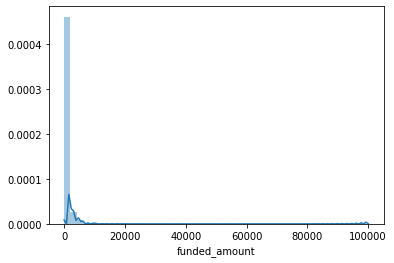

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(kiva['funded_amount'])

In [8]:
# I need to remove some outliers for my target for visualization

kivaT = kiva[kiva['funded_amount'] <= 10000]

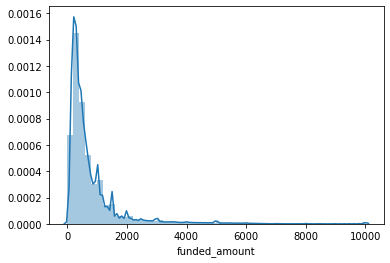

In [9]:
#trying this again 
sns.distplot(kivaT['funded_amount'])

###Data runs on the lower end due to most loans being for smaller amounts 

###May need to Logritmically transform the data to make it easier for the model to predict 

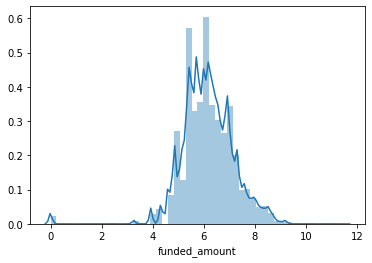

In [10]:
import numpy as np

log_funding = np.log1p(kiva['funded_amount'])
sns.distplot(log_funding)

Make sure to convert predictions back to us dollars with np.expm1

#Metrics

I want to use RMSE because my bussiness problem calls for my model to be as accurate as possible to give the borrowers the greatest chance of thier loan amount being granted. I also want to penalize values further from the actual because in practice if the requested loan is close it may still be accepted but if it's way off it may lead to loans never being realized.

#Observation Selection 

I don't want to get rid of the outliers in this case because I know from my data exploration in the unit one build that the high outliers have a meaning in that they are assosiated with higher cost of living parts of the world and industries that are in need of larger loan amounts such as Entertainment and on the low end it's skewed towards countries where the US dollar goes the farthest since the target measurments are in US dollars. Removing outliers would decrease my predictive power for these instances 

I want to split on time because I'm concered with predicting what the loan amounts will be as close to today as I can get, as opposed to in 2015 

#Begining cleaning and removing features that will cause data leakage

In [11]:
#calling columns again to get a quick glance right off the bat on what needs to be removed
list(kiva.columns)

['id',
 'funded_amount',
 'loan_amount',
 'activity',
 'sector',
 'use',
 'country_code',
 'country',
 'region',
 'currency',
 'partner_id',
 'posted_time',
 'disbursed_time',
 'funded_time',
 'term_in_months',
 'lender_count',
 'tags',
 'borrower_genders',
 'repayment_interval',
 'date']

In [12]:
#know I need to drop loan_amount because it's what is used to create funded_amount 
#need to remove dispursed time and funded time because that's data I wouldn't have when making predictions in the business context
kiva = kiva.drop(columns=['loan_amount', 'disbursed_time', 'funded_time'])

In [13]:
list(kiva.columns)

['id',
 'funded_amount',
 'activity',
 'sector',
 'use',
 'country_code',
 'country',
 'region',
 'currency',
 'partner_id',
 'posted_time',
 'term_in_months',
 'lender_count',
 'tags',
 'borrower_genders',
 'repayment_interval',
 'date']

In [14]:
#finding high cardinality features
kiva.nunique()

id                    671205
funded_amount            610
activity                 163
sector                    15
use                   424912
country_code              86
country                   87
region                 12695
currency                  67
partner_id               366
posted_time           667399
term_in_months           148
lender_count             503
tags                   86719
borrower_genders       11298
repayment_interval         4
date                    1298
dtype: int64

In [15]:
#removing ID, Use (for now until nlp), tags (again for now until nlp), date because its the same as posted date with less info and region
kiva = kiva.drop(columns=['id', 'use', 'region', 'tags', 'date', 'lender_count', 'partner_id'])

In [16]:
#engineering Gender to be usable with less cardinality 
kiva['single_gender'] = 'More than 1 borrower'

#locking the single borrowers to thier gender 
kiva.loc[kiva['borrower_genders'] == 'male', 'single_gender'] = 'male'
kiva.loc[kiva['borrower_genders'] == 'female', 'single_gender'] = 'female'

kiva.drop('borrower_genders', axis=1, inplace=True)
kiva.head()

,funded_amount,activity,sector,country_code,country,currency,posted_time,term_in_months,repayment_interval,single_gender
0,300.0,Fruits & Vegetables,Food,PK,Pakistan,PKR,2014-01-01 06:12:39+00:00,12.0,irregular,female
1,575.0,Rickshaw,Transportation,PK,Pakistan,PKR,2014-01-01 06:51:08+00:00,11.0,irregular,More than 1 borrower
2,150.0,Transportation,Transportation,IN,India,INR,2014-01-01 09:58:07+00:00,43.0,bullet,female
3,200.0,Embroidery,Arts,PK,Pakistan,PKR,2014-01-01 08:03:11+00:00,11.0,irregular,female
4,400.0,Milk Sales,Food,PK,Pakistan,PKR,2014-01-01 11:53:19+00:00,14.0,monthly,female


In [19]:
kiva.nunique()

funded_amount            610
activity                 163
sector                    15
country_code              86
country                   87
currency                  67
posted_time           667399
term_in_months           148
repayment_interval         4
single_gender              3
dtype: int64